<a href="https://colab.research.google.com/github/Sara-DaCanal/Progetto-ML/blob/main/progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto di Machine Learning

* Adrian Petru Baba
* Sara Da Canal

### Introduzione

Questo Notebook propone l'analisi di modelli di Machine Learning usati per eseguire una classificazione binaria su un dataset di funghi, per stabilire se sono edibili o velenosi. Inizialmente abbiamo effettuato una fase di preprocessing dei dati, per andare ad ottenere un dataset di qualità, poi siamo andati a testare differenti modelli di machine learning effettuando tuning dei parametri per stabilire quale modello è il migliore per il task considerato.

In [1]:
import pandas as pd
from typing import Tuple
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
path_to_dataset = '/content/drive/MyDrive/secondary_data_shuffled.csv'

In [25]:
df = pd.read_csv(path_to_dataset, sep=';')
print(df.columns)
print(df.shape)

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')
(61069, 21)


Abbiamo letto il dataset importandolo come un Dataframe pandas.
Come si può vedere qui sopra, il dataset comprende 21 colonne, di cui 20 sono feature è la prima è il valore target, e 61.069 righe. Di queste colonne, tre hanno valori numerici, mentre tutte le altre presentano valori categorici. Sotto è possibile vedere quali feature appartengono a ciascuna categoria.

In [26]:
df['cap-shape'].replace(to_replace = 'b', value='bell', inplace=True)
df['cap-shape'].replace(to_replace = 'c', value='conical', inplace=True)
df['cap-shape'].replace(to_replace = 'x', value='convex', inplace=True)
df['cap-shape'].replace(to_replace = 'f', value='flat', inplace=True)
df['cap-shape'].replace(to_replace = 's', value='sunken', inplace=True)
df['cap-shape'].replace(to_replace = 'p', value='spherical', inplace=True)
df['cap-shape'].replace(to_replace = '0', value='other', inplace=True)

df['cap-surface'].replace(to_replace = 'i', value='fibrous', inplace=True)
df['cap-surface'].replace(to_replace = 'g', value='grooves', inplace=True)
df['cap-surface'].replace(to_replace = 'y', value='scaly', inplace=True)
df['cap-surface'].replace(to_replace = 's', value='smooth', inplace=True)
df['cap-surface'].replace(to_replace = 'd', value='dry', inplace=True)
df['cap-surface'].replace(to_replace = 'h', value='shiny', inplace=True)
df['cap-surface'].replace(to_replace = 'l', value='leathery', inplace=True)
df['cap-surface'].replace(to_replace = 'k', value='silky', inplace=True)
df['cap-surface'].replace(to_replace = 't', value='sticky', inplace=True)
df['cap-surface'].replace(to_replace = 'w', value='wrinkled', inplace=True)
df['cap-surface'].replace(to_replace = 'e', value='fleshy', inplace=True)

df['cap-color'].replace(to_replace = 'n', value='brown', inplace=True)
df['cap-color'].replace(to_replace = 'b', value='buff', inplace=True)
df['cap-color'].replace(to_replace = 'g', value='grey', inplace=True)
df['cap-color'].replace(to_replace = 'r', value='green', inplace=True)
df['cap-color'].replace(to_replace = 'p', value='pink', inplace=True)
df['cap-color'].replace(to_replace = 'u', value='purple', inplace=True)
df['cap-color'].replace(to_replace = 'e', value='red', inplace=True)
df['cap-color'].replace(to_replace = 'w', value='white', inplace=True)
df['cap-color'].replace(to_replace = 'y', value='yellow', inplace=True)
df['cap-color'].replace(to_replace = 'l', value='blue', inplace=True)
df['cap-color'].replace(to_replace = 'o', value='orange', inplace=True)
df['cap-color'].replace(to_replace = 'k', value='black', inplace=True)

df['does-bruise-or-bleed'].replace(to_replace = 't', value=1, inplace=True)
df['does-bruise-or-bleed'].replace(to_replace = 'f', value=0, inplace=True)

df['gill-attachment'].replace(to_replace = 'a', value='adnate', inplace=True)
df['gill-attachment'].replace(to_replace = 'x', value='adnexed', inplace=True)
df['gill-attachment'].replace(to_replace = 'd', value='decurrent', inplace=True)
df['gill-attachment'].replace(to_replace = 'e', value='free', inplace=True)
df['gill-attachment'].replace(to_replace = 's', value='sinuate', inplace=True)
df['gill-attachment'].replace(to_replace = 'p', value='pores', inplace=True)
df['gill-attachment'].replace(to_replace = 'f', value='none', inplace=True)
df['gill-attachment'].replace(to_replace = '?', value='unknown', inplace=True)

df['gill-spacing'].replace(to_replace = 'c', value='close', inplace=True)
df['gill-spacing'].replace(to_replace = 'd', value='distant', inplace=True)
df['gill-spacing'].replace(to_replace = 'f', value='none', inplace=True)

df['gill-color'].replace(to_replace = 'n', value='brown', inplace=True)
df['gill-color'].replace(to_replace = 'b', value='buff', inplace=True)
df['gill-color'].replace(to_replace = 'g', value='grey', inplace=True)
df['gill-color'].replace(to_replace = 'r', value='green', inplace=True)
df['gill-color'].replace(to_replace = 'p', value='pink', inplace=True)
df['gill-color'].replace(to_replace = 'u', value='purple', inplace=True)
df['gill-color'].replace(to_replace = 'e', value='red', inplace=True)
df['gill-color'].replace(to_replace = 'w', value='white', inplace=True)
df['gill-color'].replace(to_replace = 'y', value='yellow', inplace=True)
df['gill-color'].replace(to_replace = 'l', value='blue', inplace=True)
df['gill-color'].replace(to_replace = 'o', value='orange', inplace=True)
df['gill-color'].replace(to_replace = 'k', value='black', inplace=True)
df['gill-color'].replace(to_replace = 'f', value='none', inplace=True)

df['stem-root'].replace(to_replace = 'b', value='bulbous', inplace=True)
df['stem-root'].replace(to_replace = 's', value='swollen', inplace=True)
df['stem-root'].replace(to_replace = 'c', value='club', inplace=True)
df['stem-root'].replace(to_replace = 'u', value='cup', inplace=True)
df['stem-root'].replace(to_replace = 'e', value='equal', inplace=True)
df['stem-root'].replace(to_replace = 'z', value='rhizomorphs', inplace=True)
df['stem-root'].replace(to_replace = 'r', value='rooted', inplace=True)

df['stem-surface'].replace(to_replace = 'i', value='fibrous', inplace=True)
df['stem-surface'].replace(to_replace = 'g', value='grooves', inplace=True)
df['stem-surface'].replace(to_replace = 'y', value='scaly', inplace=True)
df['stem-surface'].replace(to_replace = 's', value='smooth', inplace=True)
df['stem-surface'].replace(to_replace = 'd', value='dry', inplace=True)
df['stem-surface'].replace(to_replace = 'h', value='shiny', inplace=True)
df['stem-surface'].replace(to_replace = 'l', value='leathery', inplace=True)
df['stem-surface'].replace(to_replace = 'k', value='silky', inplace=True)
df['stem-surface'].replace(to_replace = 't', value='sticky', inplace=True)
df['stem-surface'].replace(to_replace = 'w', value='wrinkled', inplace=True)
df['stem-surface'].replace(to_replace = 'e', value='fleshy', inplace=True)
df['stem-surface'].replace(to_replace = 'f', value='none', inplace=True)

df['stem-color'].replace(to_replace = 'n', value='brown', inplace=True)
df['stem-color'].replace(to_replace = 'b', value='buff', inplace=True)
df['stem-color'].replace(to_replace = 'g', value='grey', inplace=True)
df['stem-color'].replace(to_replace = 'r', value='green', inplace=True)
df['stem-color'].replace(to_replace = 'p', value='pink', inplace=True)
df['stem-color'].replace(to_replace = 'u', value='purple', inplace=True)
df['stem-color'].replace(to_replace = 'e', value='red', inplace=True)
df['stem-color'].replace(to_replace = 'w', value='white', inplace=True)
df['stem-color'].replace(to_replace = 'y', value='yellow', inplace=True)
df['stem-color'].replace(to_replace = 'l', value='blue', inplace=True)
df['stem-color'].replace(to_replace = 'o', value='orange', inplace=True)
df['stem-color'].replace(to_replace = 'k', value='black', inplace=True)
df['stem-color'].replace(to_replace = 'f', value='none', inplace=True)

df['veil-type'].replace(to_replace = 'p', value=0, inplace=True)
df['veil-type'].replace(to_replace = 'u', value=1, inplace=True)

df['veil-color'].replace(to_replace = 'n', value='brown', inplace=True)
df['veil-color'].replace(to_replace = 'b', value='buff', inplace=True)
df['veil-color'].replace(to_replace = 'g', value='grey', inplace=True)
df['veil-color'].replace(to_replace = 'r', value='green', inplace=True)
df['veil-color'].replace(to_replace = 'p', value='pink', inplace=True)
df['veil-color'].replace(to_replace = 'u', value='purple', inplace=True)
df['veil-color'].replace(to_replace = 'e', value='red', inplace=True)
df['veil-color'].replace(to_replace = 'w', value='white', inplace=True)
df['veil-color'].replace(to_replace = 'y', value='yellow', inplace=True)
df['veil-color'].replace(to_replace = 'l', value='blue', inplace=True)
df['veil-color'].replace(to_replace = 'o', value='orange', inplace=True)
df['veil-color'].replace(to_replace = 'k', value='black', inplace=True)
df['veil-color'].replace(to_replace = 'f', value='none', inplace=True)

df['has-ring'].replace(to_replace = 't', value=1, inplace=True)
df['has-ring'].replace(to_replace = 'f', value=0, inplace=True)

df['ring-type'].replace(to_replace = 'c', value='cobwebby', inplace=True)
df['ring-type'].replace(to_replace = 'e', value='evanescent', inplace=True)
df['ring-type'].replace(to_replace = 'r', value='flaring', inplace=True)
df['ring-type'].replace(to_replace = 'g', value='grooved', inplace=True)
df['ring-type'].replace(to_replace = 'l', value='large', inplace=True)
df['ring-type'].replace(to_replace = 'p', value='pendant', inplace=True)
df['ring-type'].replace(to_replace = 's', value='sheathing', inplace=True)
df['ring-type'].replace(to_replace = 'z', value='zone', inplace=True)
df['ring-type'].replace(to_replace = 'y', value='scaly', inplace=True)
df['ring-type'].replace(to_replace = 'm', value='movable', inplace=True)
df['ring-type'].replace(to_replace = 'f', value='none', inplace=True)

df['spore-print-color'].replace(to_replace = 'n', value='brown', inplace=True)
df['spore-print-color'].replace(to_replace = 'b', value='buff', inplace=True)
df['spore-print-color'].replace(to_replace = 'g', value='grey', inplace=True)
df['spore-print-color'].replace(to_replace = 'r', value='green', inplace=True)
df['spore-print-color'].replace(to_replace = 'p', value='pink', inplace=True)
df['spore-print-color'].replace(to_replace = 'u', value='purple', inplace=True)
df['spore-print-color'].replace(to_replace = 'e', value='red', inplace=True)
df['spore-print-color'].replace(to_replace = 'w', value='white', inplace=True)
df['spore-print-color'].replace(to_replace = 'y', value='yellow', inplace=True)
df['spore-print-color'].replace(to_replace = 'l', value='blue', inplace=True)
df['spore-print-color'].replace(to_replace = 'o', value='orange', inplace=True)
df['spore-print-color'].replace(to_replace = 'k', value='black', inplace=True)

df['habitat'].replace(to_replace = 'g', value='grasses', inplace=True)
df['habitat'].replace(to_replace = 'l', value='leaves', inplace=True)
df['habitat'].replace(to_replace = 'm', value='meadows', inplace=True)
df['habitat'].replace(to_replace = 'p', value='paths', inplace=True)
df['habitat'].replace(to_replace = 'h', value='heaths', inplace=True)
df['habitat'].replace(to_replace = 'u', value='urban', inplace=True)
df['habitat'].replace(to_replace = 'w', value='waste', inplace=True)
df['habitat'].replace(to_replace = 'd', value='woods', inplace=True)

df['season'].replace(to_replace = 's', value='spring', inplace=True)
df['season'].replace(to_replace = 'u', value='summer', inplace=True)
df['season'].replace(to_replace = 'w', value='winter', inplace=True)
df['season'].replace(to_replace = 'a', value='autumn', inplace=True)

df['class'].replace(to_replace = 'e', value=1, inplace=True)
df['class'].replace(to_replace = 'p', value=0, inplace=True)

In [27]:
print(df)

       class  cap-diameter cap-shape cap-surface cap-color  \
0          1          1.72    convex      smooth    yellow   
1          1          9.59      flat      fleshy      buff   
2          0          0.86    convex     grooves      pink   
3          0          4.32    convex         NaN       red   
4          1          2.80    convex      smooth     white   
...      ...           ...       ...         ...       ...   
61064      0         13.81    convex       silky     brown   
61065      0          2.69    convex         dry     white   
61066      1         11.70      flat         NaN      grey   
61067      0          2.83    sunken    wrinkled    purple   
61068      0          1.57    convex     fibrous      blue   

       does-bruise-or-bleed gill-attachment gill-spacing gill-color  \
0                         0       decurrent          NaN      white   
1                         0             NaN        close       buff   
2                         0          adnat

In [28]:
numerical_cols = df.select_dtypes(include='number').columns.to_list()
print("Le feature numeriche sono:" ,numerical_cols)
print("Il numero di feature numeriche è:", len(numerical_cols))
categorical_cols = df.select_dtypes(include='object').columns.to_list()
print("Le feature categoriche sono:" ,categorical_cols)
print("Il numero di feature categoriche è:", len(categorical_cols))

Le feature numeriche sono: ['class', 'cap-diameter', 'does-bruise-or-bleed', 'stem-height', 'stem-width', 'veil-type', 'has-ring']
Il numero di feature numeriche è: 7
Le feature categoriche sono: ['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-color', 'ring-type', 'spore-print-color', 'habitat', 'season']
Il numero di feature categoriche è: 14


# Preprocessing del dataset
Per andare ad ottenere un dataset coerente siamo andati a verificare la presenza di valori nulli nelle colonne, usando la seguente funzione:

In [29]:
def get_nan_cols(dataset: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Index]:
    """ Restituisce:
        0: un dataframe con nome colonna, numero null
        1: una lista (Index) con i nomi delle colonne che hanno valori nulli
    """
    count_nan = dataset.isnull().sum(axis=0)
    columns_with_nan_df = count_nan.loc[count_nan != 0]
    nan_cols_names = dataset.columns[dataset.isna().any()]
    return columns_with_nan_df, nan_cols_names

nan_cols, nan_list = get_nan_cols(df)
print(nan_cols)

cap-surface          14120
gill-attachment       9884
gill-spacing         25063
stem-root            51538
stem-surface         38124
veil-type            57892
veil-color           53656
ring-type             2471
spore-print-color    54715
dtype: int64


Come si può vedere dall'output, abbiamo valori nulli in 9 colonne su 20.

In questa fase abbiamo eliminato dal dataset le colonne relative a feature in cui c'è una percentuale di valori nulli maggiore rispetto a una specifica soglia (nello specifico **75%**).
Possiamo vedere il numero minimo di valori non nulli richiesto per non cancellare la colonna.
Dal numero iniziale, con questa pulizia rimangono solo **14** feature.

In [30]:
righe = df.shape[0]
p = 0.75
def remove_nan_columns(dataset: pd.DataFrame, threshold) -> pd.DataFrame:
    """Elimina colonne con valori NaN quando i valori Nan sono superiori a [threshold]%"""
    thresh = int((len(dataset) * threshold)) + 1
    print("Numero di valori non nulli minimo: ", thresh)
    # axis: specifichiamo di eliminare solo le colonne; thresh: numero minimo per eliminare
    dataset.dropna(axis='columns', thresh=thresh, inplace=True)
    return dataset

new_data = remove_nan_columns(df, p)
print("Il numero di feature ora è:" ,new_data.shape[1])



Numero di valori non nulli minimo:  45802
Il numero di feature ora è: 15


In [31]:
numerical_cols = df.select_dtypes(include='number').columns.to_list()

categorical_cols = df.select_dtypes(include='object').columns.to_list()

Di seguito possiamo vedere quali, fra le rimanenti feature, hanno qualche valore nullo (ma non a sufficienza per essere cancellate in base al threshold scelto).
Di fatto, tra le colonne riguardanti feature con valori numerici, non abbiamo alcun valore null; al contrario, per le feature con valori categorici, abbiamo diversi null.
Nel primo caso, qualora ce ne fosse stato bisogno, i valori mancanti sarebbero potuti essere riempiti per esempio dalla media del valore di quella feature o con qualche strategia simile.
Nel secondo caso, abbiamo scelto di riempire gli spazi vuoti con la moda del valore della feature corrispondente.

In [32]:
nan_cols, nan_list = get_nan_cols(df)
print(nan_cols)

cap-surface        14120
gill-attachment     9884
ring-type           2471
dtype: int64


Il grafico seguente mostra, nelle colonne dove abbiamo dei NaN, la media tra

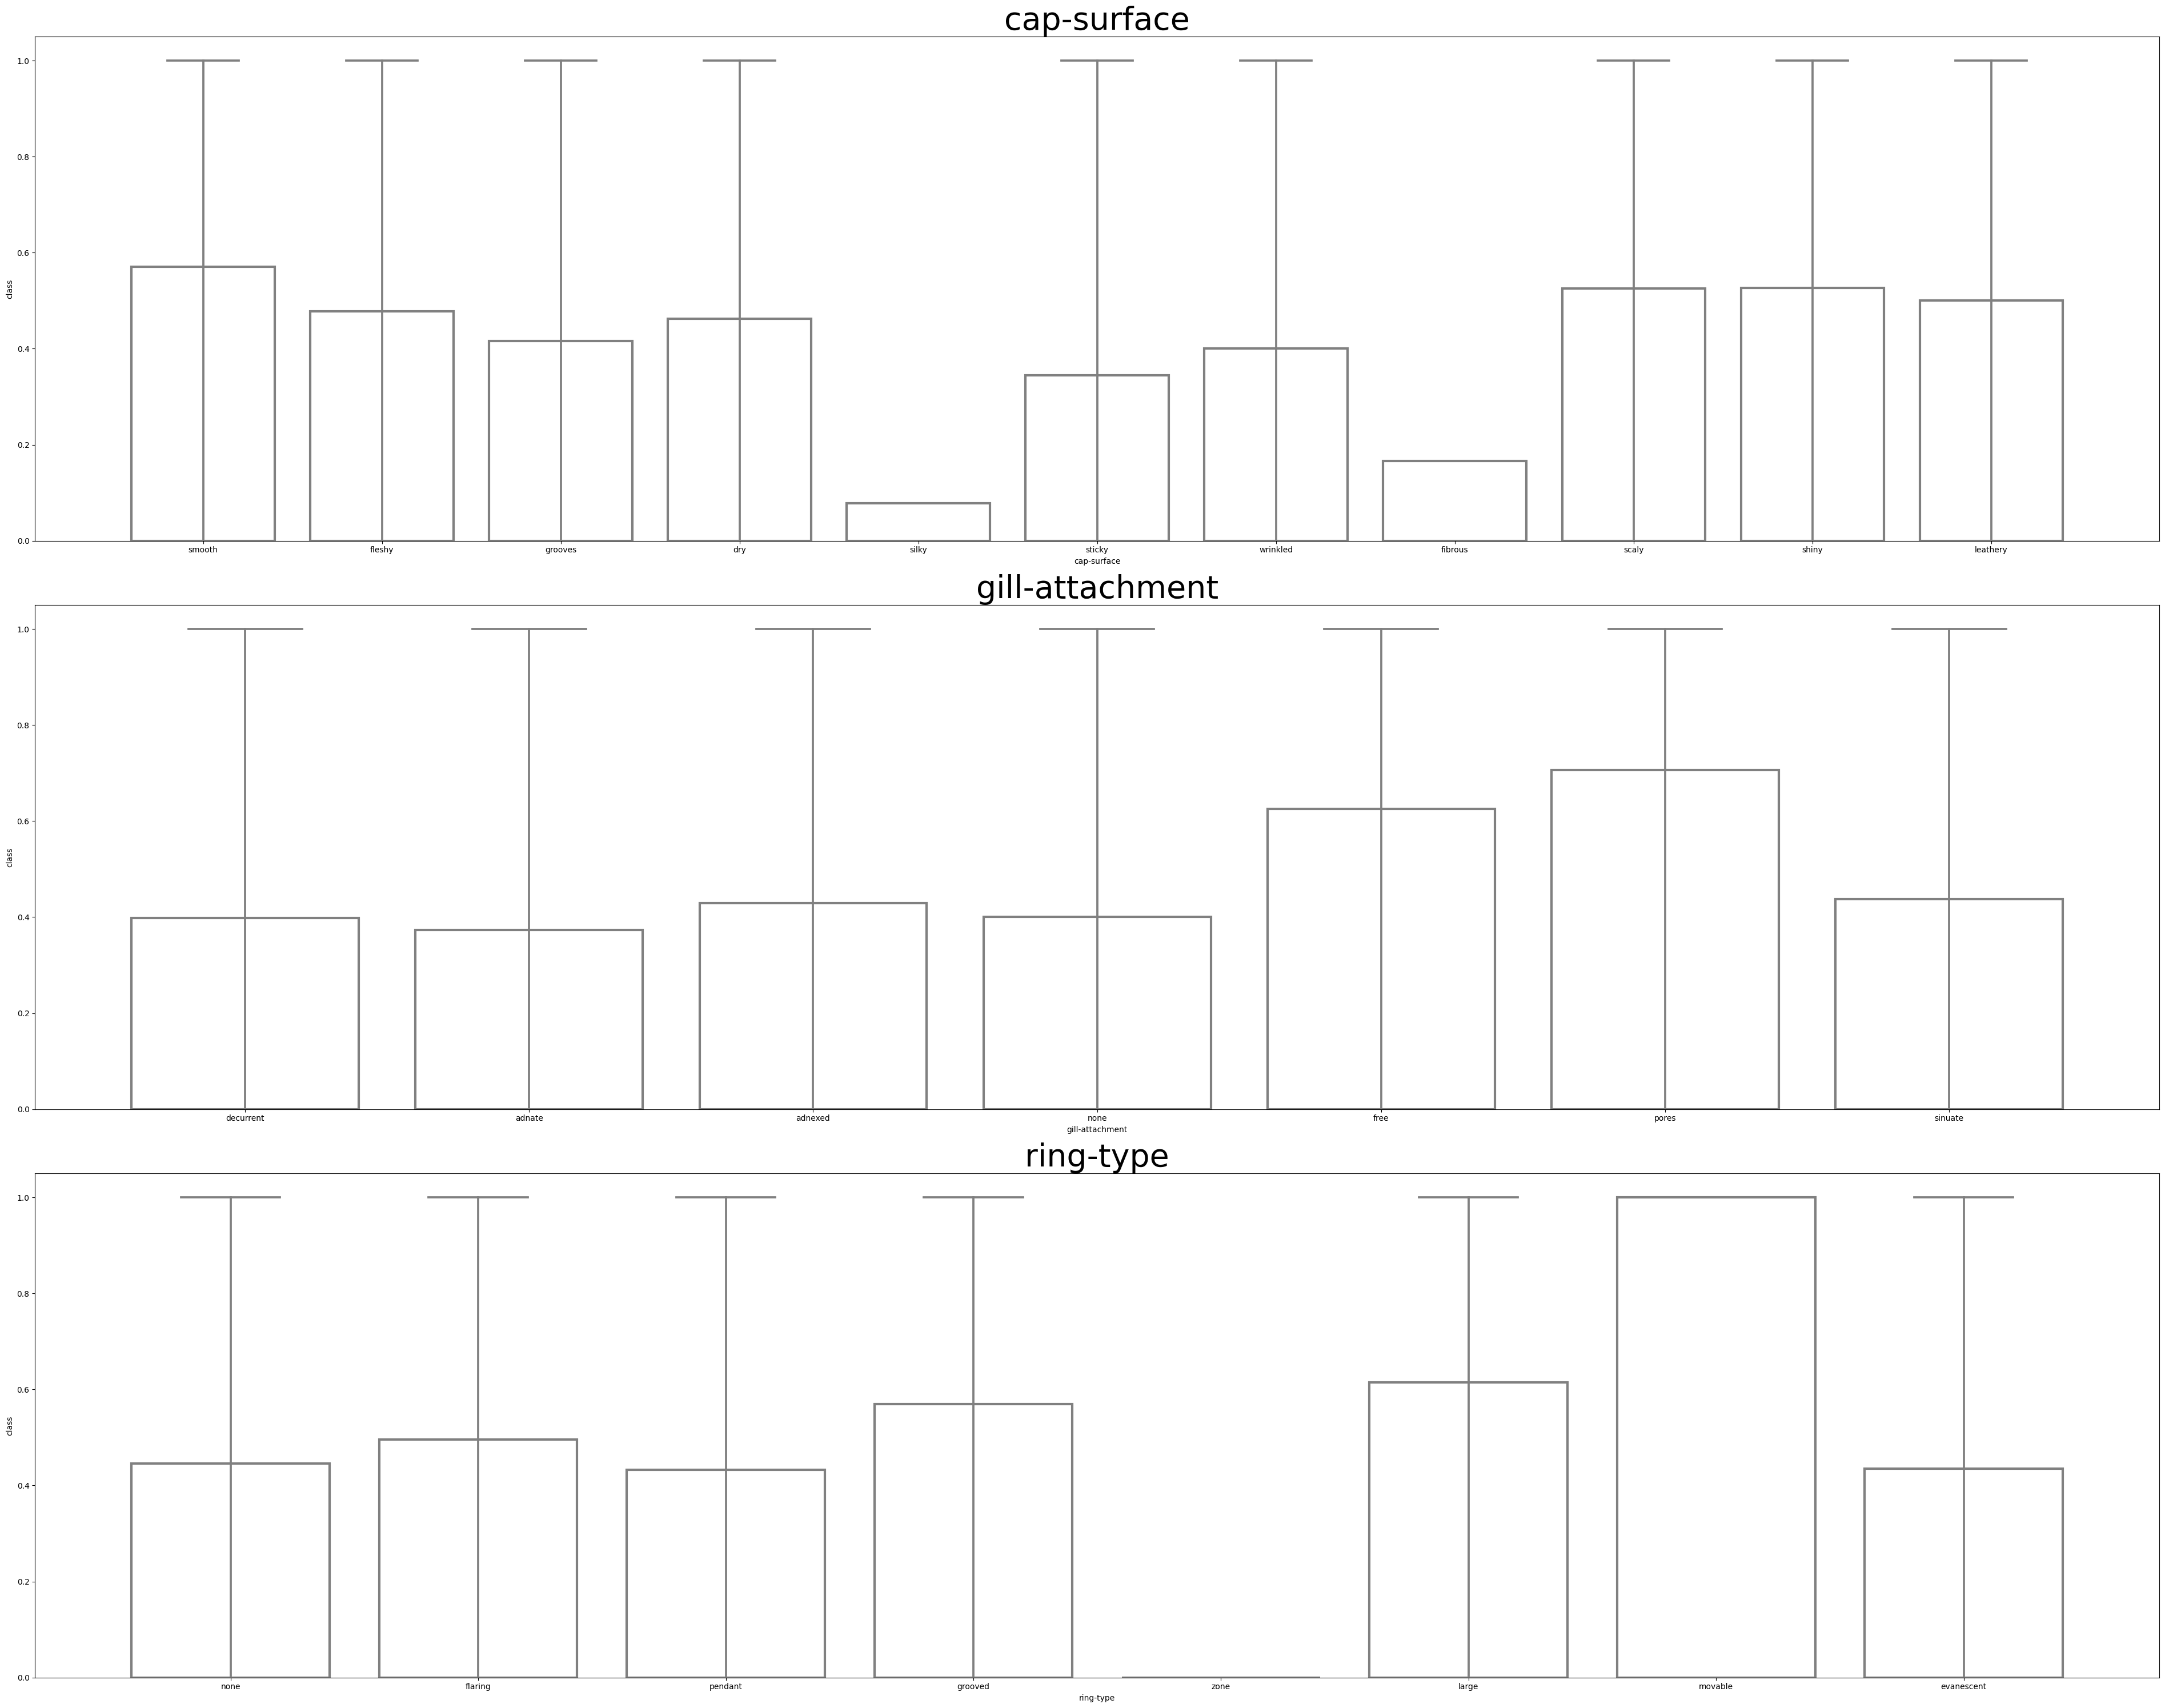

In [33]:

target = 'class'


fig, axes = plt.subplots(3, 1, figsize=(38, 30))
axis_x = 0
for col in nan_list:
  f = sns.barplot(data=df, x=col, y=target,
    errorbar=("pi", 50), capsize=.4, errcolor=".5",
    linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),ax=axes[axis_x])
  f.axis(ymin=0, ymax=800000)
  f.set_title(col, fontsize=40)
  axes[axis_x].tick_params(rotation=0)
  axes[axis_x].autoscale(enable=True)
  fig.tight_layout()
  axis_x +=1


sticky
sticky      36.542272
smooth      12.458039
scaly       10.383337
shiny        8.144885
grooves      7.735512
dry          7.257365
fleshy       4.231279
silky        3.771144
fibrous      3.643420
wrinkled     3.520608
leathery     2.312139
Name: cap-surface, dtype: float64
adnate
adnate       36.977845
decurrent    16.779381
adnexed      12.138728
pores         9.826590
free          9.248555
sinuate       9.248555
none          5.780347
Name: gill-attachment, dtype: float64
none
none          83.236994
evanescent     3.987293
zone           3.468208
large          2.336701
flaring        2.290851
pendant        2.071427
grooved        2.030490
movable        0.578035
Name: ring-type, dtype: float64


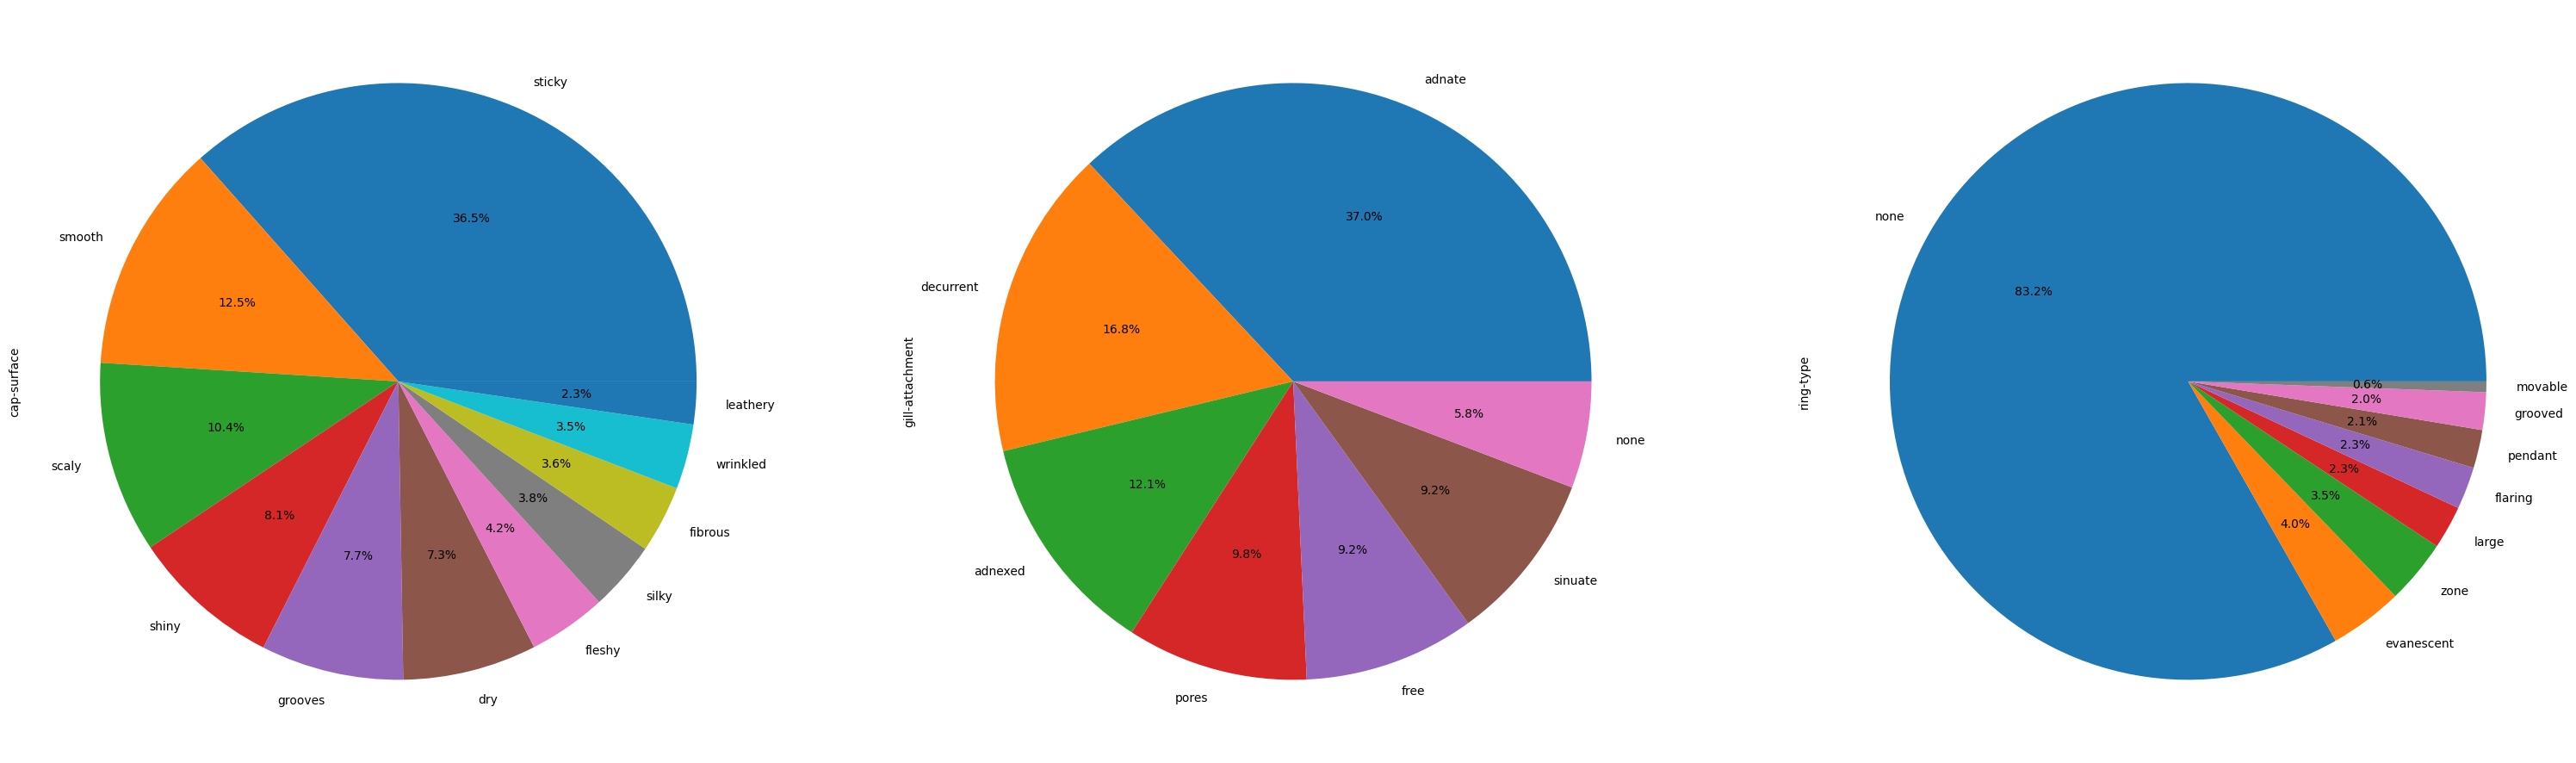

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(38, 15))
y=0
for elem in categorical_cols:
  if elem in nan_list:
    col = df[elem]
    mode = col.mode()
    print(mode.iloc[0])
    df1 = col.fillna(mode.iloc[0], inplace=True)
    percentages = col.value_counts(normalize=True) * 100
    print(percentages)
    percentages.plot.pie(ax=axes[y], autopct='%1.1f%%')
    y+=1


In [ ]:
print('Number of positive items: {0:d}'.format(df[df.columns['class']==1].shape[0]))
print('Number of negative items: {0:d}'.format(df[df.columns['class']==0].shape[0]))
print('Fraction of positive items: {0:3.2f}'.format(df[df.Survived==1].shape[0]/df.shape[0]))

In [36]:
df_encoded = pd.get_dummies(df, columns=categorical_cols[1:])
print(df_encoded)

       class  cap-diameter cap-shape  does-bruise-or-bleed  stem-height  \
0          1          1.72    convex                     0         7.01   
1          1          9.59      flat                     0         4.73   
2          0          0.86    convex                     0         4.25   
3          0          4.32    convex                     0         4.91   
4          1          2.80    convex                     0         3.13   
...      ...           ...       ...                   ...          ...   
61064      0         13.81    convex                     1        10.06   
61065      0          2.69    convex                     0         3.76   
61066      1         11.70      flat                     0         7.36   
61067      0          2.83    sunken                     0         5.76   
61068      0          1.57    convex                     0         3.26   

       stem-width  has-ring  cap-surface_dry  cap-surface_fibrous  \
0            2.36         0   

In [ ]:
sns.pairplot(df_encoded[df_encoded.columns], height=4, diag_kind='kde',
             plot_kws=dict(color='blue'),
             diag_kws=dict(fill=True, alpha=.7, color='red'))